**OFI Case Study:** 

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional style for all charts
sns.set_theme(style="darkgrid", palette="deep")

# Define the path to the data
DATA_PATH = r"E:\AI INTERN\Data"

In [11]:
# --- NEW DERIVED COLUMN NAMES ---
NEW_KEY_ON_TIME = "On-Time Status"
NEW_KEY_OVERRUN_DAYS = "Delivery Overrun (days)"
NEW_KEY_TOTAL_COST = "Total Order Cost"

In [12]:
def load_all_data(data_path: str) -> dict:
    """
    Loads all 7 CSV files into a dictionary of DataFrames.

    Args:
        data_path (str): The relative path to the data folder.

    Returns:
        dict: A dictionary of DataFrames.
    """
    print(f"--- Loading Data from '{data_path}' ---")
    datasets = [
        "orders.csv", "delivery_performance.csv", "routes_distance.csv",
        "vehicle_fleet.csv", "warehouse_inventory.csv",
        "customer_feedback.csv", "cost_breakdown.csv"
    ]
    data_frames = {}
    
    try:
        for file in datasets:
            file_path = os.path.join(data_path, file)
            df_name = file.split('.')[0]
            data_frames[df_name] = pd.read_csv(file_path)
            print(f"[SUCCESS] Loaded {file} ({len(data_frames[df_name])} records)")
            
        print("--- All datasets loaded successfully. --- \n")
        return data_frames
        
    except FileNotFoundError as e:
        print(f"[ERROR] File not found: {e}.")
        print(f"Please ensure all 7 CSV files are in the '{data_path}' subfolder.")
        return None
    except Exception as e:
        print(f"[ERROR] An error occurred during data loading: {e}")
        return None

In [13]:
def find_column_name(df_columns: list, potential_names: list) -> str:
    """
    Finds the first matching column name from a list of potentials.
    
    Args:
        df_columns (list): The list of columns from the DataFrame.
        potential_names (list): A list of possible names (e.g., "Order_ID", "order_id").
    
    Returns:
        str: The matching column name, or None if not found.
    """
    for name in potential_names:
        if name in df_columns:
            return name
    return None

In [14]:
def analyze_data(data_frames: dict) -> (pd.DataFrame, pd.DataFrame, dict):
    """
    Performs core analysis, data cleaning, and metric derivation
    by *finding* correct column names without renaming.
    (Version 10: More robust key finding)

    Args:
        data_frames (dict): The dictionary of DataFrames from load_all_data.

    Returns:
        tuple: (df_completed, df_pending, keys)
               Returns (None, None, None) if analysis fails.
    """
    if data_frames is None:
        return None, None, None

    # --- 3.a. Find Critical Column Names (No Renaming) ---
    print("--- Finding Critical Column Names ---")
    
    # Get all column lists
    cols_orders = data_frames["orders"].columns
    cols_delivery = data_frames["delivery_performance"].columns
    cols_cost = data_frames["cost_breakdown"].columns

    # Store all found keys in a dictionary
    keys = {}

    # Define potential names and find them
    keys["order_id"] = find_column_name(cols_orders, ["Order_ID", "order_id", "Order ID"])
    keys["order_value"] = find_column_name(cols_orders, ["Order_Value_INR", "Order Value", "order_value", "order_val", "OrderValue"])
    keys["priority"] = find_column_name(cols_orders, ["Priority", "priority", "Order_Priority"])
    
    key_order_id_delivery = find_column_name(cols_delivery, ["Order_ID", "order_id", "Order ID"])
    key_order_id_cost = find_column_name(cols_cost, ["Order_ID", "order_id", "Order ID"])
    
    keys["delivery_status"] = find_column_name(cols_delivery, ["Delivery_Status", "Delivery Status", "delivery_status"])
    
    keys["promised_days"] = find_column_name(cols_delivery, ["promised_delivery_days", "Promised_Delivery_Days", "Promised Delivery Days"])
    keys["actual_days"] = find_column_name(cols_delivery, ["actual_delivery_days", "Actual_Delivery_Days", "Actual Delivery Days"])
    
    keys["quality_issues"] = find_column_name(cols_delivery, [
        "Quality_Issues", "Quality_Issue", "Quality Issues", "quality_issues", 
        "quality_issue", "issue"
    ])
    
    keys["customer_rating"] = find_column_name(cols_delivery, ["Customer_Rating", "Customer Rating (1-5)", "Customer Rating", "customer_rating", "rating"])

    keys["cost_cols_list"] = [
        "Fuel_Cost", "Fuel Costs", "Labor_Cost", "Labor Costs",
        "Vehicle_Maintenance", "Maintenance Costs", "Insurance", "Insurance Costs",
        "Packaging_Cost", "Packaging Costs", "Technology_Platform_Fee", "Technology Platform Fees", "Other_Overhead"
    ]
    keys["existing_cost_cols"] = [col for col in keys["cost_cols_list"] if col in cols_cost]

    # --- 3.b. Validation of Critical Columns ---
    if not keys["order_id"]:
        print("[FATAL ERROR] Could not find 'Order_ID' in orders.csv. Stopping analysis.")
        return None, None, None
    if not key_order_id_delivery:
        print("[FATAL ERROR] Could not find 'Order_ID' in delivery_performance.csv. Stopping analysis.")
        return None, None, None
    if not keys["delivery_status"]:
        print("[FATAL ERROR] Could not find 'Delivery_Status' in delivery_performance.csv. Stopping analysis.")
        return None, None, None
        
    print(f"Found merge key: '{keys['order_id']}'")
    print(f"Found status key: '{keys['delivery_status']}'")

    # --- 3.c. Handle Missing Data Appropriately ---
    print("\n--- Handling Missing Data ---")
    
    df_merged = pd.merge(
        data_frames["orders"],
        data_frames["delivery_performance"],
        on=keys["order_id"],
        how="left"
    )
    
    pending_orders_df = df_merged[df_merged[keys["delivery_status"]].isna()]
    num_pending = len(pending_orders_df)
    print(f"Identified {num_pending} pending/in-transit orders "
          f"(where '{keys['delivery_status']}' is NaN).")
    
    df_completed = df_merged.dropna(subset=[keys["delivery_status"]]).copy()
    print(f"Created main analysis set with {len(df_completed)} "
          "completed deliveries.")

    if keys["quality_issues"]:
        df_completed.loc[:, keys["quality_issues"]] = \
            df_completed[keys["quality_issues"]].fillna("None")
        print(f"Filled '{keys['quality_issues']}' NaN values with 'None' category.")
    else:
        print("[INFO] 'Quality Issues' column not found. Skipping fillna.")
    
    # --- 4. Create Derived Metrics That Add Business Value ---
    print("\n--- Creating Derived Metrics ---")

    if keys["promised_days"] and keys["actual_days"]:
        try:
            df_completed[keys["promised_days"]] = pd.to_numeric(df_completed[keys["promised_days"]])
            df_completed[keys["actual_days"]] = pd.to_numeric(df_completed[keys["actual_days"]])

            # Metric 1: On-Time Status
            df_completed.loc[:, NEW_KEY_ON_TIME] = np.where(
                df_completed[keys["actual_days"]] <= df_completed[keys["promised_days"]],
                "On-Time",
                "Delayed"
            )
            print(f"Derived Metric: '{NEW_KEY_ON_TIME}' (On-Time/Delayed)")

            # Metric 2: Delivery Overrun (days)
            df_completed.loc[:, NEW_KEY_OVERRUN_DAYS] = \
                df_completed[keys["actual_days"]] - df_completed[keys["promised_days"]]
            print(f"Derived Metric: '{NEW_KEY_OVERRUN_DAYS}' (e.g., -1, 0, 2)")
        
        except Exception as e:
            print(f"[WARNING] Could not derive numeric metrics due to an error: {e}")
            df_completed.loc[:, NEW_KEY_ON_TIME] = "Unknown"
            df_completed.loc[:, NEW_KEY_OVERRUN_DAYS] = 0
    else:
        print("[INFO] 'promised_delivery_days' or 'actual_delivery_days' not found. Skipping duration-based metrics.")
        df_completed.loc[:, NEW_KEY_ON_TIME] = "Unknown"
        df_completed.loc[:, NEW_KEY_OVERRUN_DAYS] = 0

    # Metric 3: Total Order Cost
    if key_order_id_cost and keys["existing_cost_cols"]:
        print(f"Found {len(keys['existing_cost_cols'])} cost columns.")
        
        data_frames["cost_breakdown"][keys["existing_cost_cols"]] = \
            data_frames["cost_breakdown"][keys["existing_cost_cols"]].fillna(0)
            
        data_frames["cost_breakdown"][NEW_KEY_TOTAL_COST] = \
            data_frames["cost_breakdown"][keys["existing_cost_cols"]].sum(axis=1)
        
        df_completed = pd.merge(
            df_completed,
            data_frames["cost_breakdown"][[key_order_id_cost, NEW_KEY_TOTAL_COST]],
            on=key_order_id_cost,
            how="left"
        )
        df_completed.loc[:, NEW_KEY_TOTAL_COST] = df_completed[NEW_KEY_TOTAL_COST].fillna(0)
        print(f"Derived Metric: '{NEW_KEY_TOTAL_COST}' (sum of all cost components)")
    else:
        print("[INFO] Skipping 'Total Order Cost' metric (key or cost columns not found).")
        df_completed.loc[:, NEW_KEY_TOTAL_COST] = 0

    print("--- Analysis & Metric Derivation Complete. --- \n")
    return df_completed, pending_orders_df, keys

In [15]:
def print_insights(df_completed: pd.DataFrame, df_pending: pd.DataFrame, keys: dict):
    """
    Performs and prints meaningful calculations and insights.

    Args:
        df_completed (pd.DataFrame): The main DataFrame of completed orders.
        df_pending (pd.DataFrame): The DataFrame of pending orders.
        keys (dict): The dictionary of *found* column names.
    """
    if df_completed is None or df_pending is None:
        print("Cannot generate insights. Analysis failed.")
        return

    print("="*40)
    print("   KEY BUSINESS & PERFORMANCE INSIGHTS")
    print("="*40)

    # Insight 1: Overall On-Time Delivery Performance
    if NEW_KEY_ON_TIME in df_completed.columns and "Unknown" not in df_completed[NEW_KEY_ON_TIME].unique():
        overall_on_time_rate = (df_completed[NEW_KEY_ON_TIME] == "On-Time").mean()
        avg_overrun = df_completed[df_completed[NEW_KEY_OVERRUN_DAYS] > 0]\
                                 [NEW_KEY_OVERRUN_DAYS].mean()
        print(f"Insight 1: Overall On-Time Rate")
        print(f"  > {overall_on_time_rate:.1%} of {len(df_completed)} completed "
              "deliveries are on-time.")
        print(f"  > When delayed, the average overrun is {avg_overrun:.1f} days.")
        print(f"  > This confirms the 'Delivery Performance Issues' "
              "are significant.\n")
    else:
        print("Insight 1: Overall On-Time Rate")
        print("  > Could not be calculated (duration columns were missing or in wrong format).\n")

    # Insight 2: Impact of Performance on Customer Satisfaction
    if (keys["customer_rating"] and NEW_KEY_ON_TIME in df_completed.columns and 
        "Unknown" not in df_completed[NEW_KEY_ON_TIME].unique()):
        try:
            avg_rating_on_time = df_completed[
                df_completed[NEW_KEY_ON_TIME] == "On-Time"
            ][keys["customer_rating"]].mean()
            avg_rating_delayed = df_completed[
                df_completed[NEW_KEY_ON_TIME] == "Delayed"
            ][keys["customer_rating"]].mean()
            print(f"Insight 2: Customer Satisfaction Impact")
            print(f"  > Avg. Customer Rating (On-Time): {avg_rating_on_time:.2f} stars")
            print(f"  > Avg. Customer Rating (Delayed): {avg_rating_delayed:.2f} stars")
            print(f"  > This shows a direct link between delays and poor ratings, "
                  "which threatens the 'customer experience'.\n")
        except Exception as e:
            print(f"Insight 2: Could not calculate Customer Satisfaction Impact. Error: {e}\n")
    else:
        print("Insight 2: Customer Satisfaction Impact")
        print("  > Could not be calculated ('Customer Rating' or duration columns missing).\n")
          
    # Insight 3: Top Causes of Quality Issues
    if keys["quality_issues"]:
        quality_counts = df_completed[
            df_completed[keys["quality_issues"]] != "None"
        ][keys["quality_issues"]].value_counts(normalize=True).head(3)
        print(f"Insight 3: Top Quality Issues (for completed orders, ex- 'None')")
        if quality_counts.empty:
            print("  > No quality issues (other than 'None') were reported.")
        else:
            print(quality_counts.to_string(header=False, float_format="{:.1%}".format))
        print(f"  > This helps identify key operational failures.\n")
    else:
        print("Insight 3: Top Quality Issues")
        print("  > Could not be calculated ('Quality Issues' column missing).\n")
    
    # Insight 4: Pending Order Value
    if (not df_pending.empty and 
        keys["order_value"] and 
        keys["priority"]):
        pending_value = df_pending[keys["order_value"]].sum()
        pending_express = (df_pending[keys["priority"]] == "Express").sum()
        print(f"Insight 4: Pending Order Pipeline")
        print(f"  > There are {len(df_pending)} orders currently pending/in-transit.")
        print(f"  > The total value of these pending orders is: ${pending_value:,.2f}")
        print(f"  > {pending_express} of these are 'Express' priority.")
        print(f"  > This is the batch our 'Smart Route Planner' will target.\n")
    else:
        print("Insight 4: Pending Order Pipeline")
        print("  > Could not be calculated ('Order Value' or 'Priority' missing from orders.csv, or no pending orders).\n")
    
    # Insight 5: Cost vs. Priority
    if (NEW_KEY_TOTAL_COST in df_completed.columns and 
        df_completed[NEW_KEY_TOTAL_COST].sum() > 0 and 
        keys["priority"]):
        cost_by_priority = df_completed.groupby(keys["priority"])\
                                       [NEW_KEY_TOTAL_COST].mean()
        print(f"Insight 5: Average Cost by Priority")
        print(cost_by_priority.to_string(float_format="${:,.2f}".format))
        
        # --- FIX: Dynamic Insight ---
        try:
            max_cost_priority = cost_by_priority.idxmax()
            max_cost_value = cost_by_priority.max()
            min_cost_priority = cost_by_priority.idxmin()
            min_cost_value = cost_by_priority.min()
            print(f"  > '{max_cost_priority}' is the most expensive priority (avg ${max_cost_value:,.2f}).")
            print(f"  > '{min_cost_priority}' is the least expensive priority (avg ${min_cost_value:,.2f}).\n")
        except Exception as e:
            print(f"  > Could not generate dynamic cost insight: {e}\n")
            
    else:
        print("Insight 5: Average Cost by Priority")
        print("  > Could not be calculated (cost or priority data was not available).\n")

In [16]:
def visualize_data(df_completed: pd.DataFrame, df_pending: pd.DataFrame, keys: dict):
    """
    Generates and displays Matplotlib/Seaborn visualizations based on the
    analysis from Step 1.

    Fulfills the requirements:
    - 4 different chart types (Pie, Bar, Histogram, Countplot).
    - Charts are appropriate for the data.
    
    Args:
        df_completed (pd.DataFrame): The main DataFrame of completed orders.
        df_pending (pd.DataFrame): The DataFrame of pending orders.
        keys (dict): The dictionary of *found* column names.
    """
    print("="*50)
    print("   STEP 2: KEY DATA VISUALIZATIONS (MATPLOTLIB/SEABORN)")
    print("="*50)
    
    # --- Chart 1: Pie Chart - Overall Delivery Performance ---
    if NEW_KEY_ON_TIME in df_completed.columns and "Unknown" not in df_completed[NEW_KEY_ON_TIME].unique():
        print("\n--- Visualization 1: Overall Delivery Performance ---")
        on_time_counts = df_completed[NEW_KEY_ON_TIME].value_counts()
        
        # Create the pie chart
        plt.figure(figsize=(7, 7))
        plt.pie(on_time_counts, 
                labels=on_time_counts.index, 
                autopct='%1.1f%%', 
                colors=['green' if label == 'On-Time' else 'crimson' for label in on_time_counts.index],
                startangle=90)
        plt.title('Chart 1: Overall Delivery Performance (On-Time vs. Delayed)', fontsize=16)
        plt.show() # Display the plot
    
    # --- Chart 2: Bar Chart - Average Cost by Priority ---
    if (keys["priority"] and NEW_KEY_TOTAL_COST in df_completed.columns and 
        df_completed[NEW_KEY_TOTAL_COST].sum() > 0):
        print("\n--- Visualization 2: Average Delivery Cost by Priority ---")
        
        # Seaborn makes this easy
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_completed, 
                    x=keys["priority"], 
                    y=NEW_KEY_TOTAL_COST, 
                    estimator=np.mean,  # Use mean for average
                    ci=None) # Turn off confidence intervals
        plt.title('Chart 2: Average Delivery Cost by Priority', fontsize=16)
        plt.xlabel('Priority Level', fontsize=12)
        plt.ylabel('Average Total Cost ($)', fontsize=12)
        plt.show()
        
    # --- Chart 3: Histogram - Distribution of Delivery Delays ---
    if (NEW_KEY_OVERRUN_DAYS in df_completed.columns and 
        (df_completed[NEW_KEY_OVERRUN_DAYS] > 0).any()):
        print("\n--- Visualization 3: Distribution of Delivery Delays (for delayed orders) ---")
        delayed_orders = df_completed[df_completed[NEW_KEY_OVERRUN_DAYS] > 0]
        
        plt.figure(figsize=(10, 6))
        sns.histplot(delayed_orders[NEW_KEY_OVERRUN_DAYS], 
                     bins=15, 
                     kde=True) # Adds a smooth density line
        plt.title('Chart 3: Distribution of Delivery Overrun (Delayed Orders Only)', fontsize=16)
        plt.xlabel('Days Delayed', fontsize=12)
        plt.ylabel('Number of Orders', fontsize=12)
        plt.show()
        
    # --- Chart 4: Count Plot (Bar Chart) - Breakdown of Quality Issues ---
    # Replaces Treemap with a clearer horizontal bar chart
    if keys["quality_issues"]:
        print("\n--- Visualization 4: Breakdown of Quality Issues ---")
        
        plt.figure(figsize=(10, 7))
        # We plot all issues *except* 'None' for a clearer chart
        sns.countplot(data=df_completed[df_completed[keys["quality_issues"]] != 'None'], 
                      y=keys["quality_issues"], # 'y' makes it horizontal
                      order=df_completed[df_completed[keys["quality_issues"]] != 'None'][keys["quality_issues"]].value_counts().index)
        plt.title('Chart 4: Count of Quality Issues (Excluding "None")', fontsize=16)
        plt.xlabel('Number of Orders', fontsize=12)
        plt.ylabel('Issue Type', fontsize=12)
        plt.show()

    # --- Chart 5 (Bonus): Scatter Plot - REMOVED ---
    # This section has been removed as requested, since 'customer_rating' column was not found.
    if (keys["customer_rating"] and NEW_KEY_OVERRUN_DAYS in df_completed.columns and
        "Unknown" not in df_completed[NEW_KEY_ON_TIME].unique()): # Also check if On-Time status could be calculated for coloring
        
        print("\n--- Visualization 5: Customer Rating vs. Delivery Delay ---")
        
        plt.figure(figsize=(10, 6))
        # Use Seaborn's regplot to automatically add a trendline
        sns.regplot(data=df_completed,
                    x=NEW_KEY_OVERRUN_DAYS, # The derived 'Delivery Overrun (days)' column
                    y=keys["customer_rating"], # The found 'customer_rating' column name
                    scatter_kws={'alpha':0.5, 's': 50}, # Make points semi-transparent and slightly larger
                    line_kws={'color':'red', 'linewidth': 2})  # Make trendline red and thicker
        
        # Add color based on On-Time status (Optional but insightful)
        # sns.scatterplot(data=df_completed, x=NEW_KEY_OVERRUN_DAYS, y=keys["customer_rating"], hue=NEW_KEY_ON_TIME, palette={'Delayed':'crimson', 'On-Time':'green'}, alpha=0.6, s=50, legend=False)

        plt.title('Chart 5: Customer Rating vs. Delivery Overrun (days)', fontsize=16)
        plt.xlabel('Delivery Overrun (Days)', fontsize=12)
        plt.ylabel('Customer Rating', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6) # Add grid lines
        plt.show()
    else:
        # This message will print if either 'customer_rating' or the overrun days columns were missing.
        print("\n[INFO] Skipping Customer Rating vs. Delay chart as required columns ('customer_rating' or delivery duration) were not found or calculable.")

--- Loading Data from 'E:\AI INTERN\Data' ---
[SUCCESS] Loaded orders.csv (200 records)
[SUCCESS] Loaded delivery_performance.csv (150 records)
[SUCCESS] Loaded routes_distance.csv (150 records)
[SUCCESS] Loaded vehicle_fleet.csv (50 records)
[SUCCESS] Loaded warehouse_inventory.csv (35 records)
[SUCCESS] Loaded customer_feedback.csv (83 records)
[SUCCESS] Loaded cost_breakdown.csv (150 records)
--- All datasets loaded successfully. --- 

--- Finding Critical Column Names ---
Found merge key: 'Order_ID'
Found status key: 'Delivery_Status'

--- Handling Missing Data ---
Identified 50 pending/in-transit orders (where 'Delivery_Status' is NaN).
Created main analysis set with 150 completed deliveries.
Filled 'Quality_Issue' NaN values with 'None' category.

--- Creating Derived Metrics ---
Derived Metric: 'On-Time Status' (On-Time/Delayed)
Derived Metric: 'Delivery Overrun (days)' (e.g., -1, 0, 2)
Found 7 cost columns.
Derived Metric: 'Total Order Cost' (sum of all cost components)
--- Ana

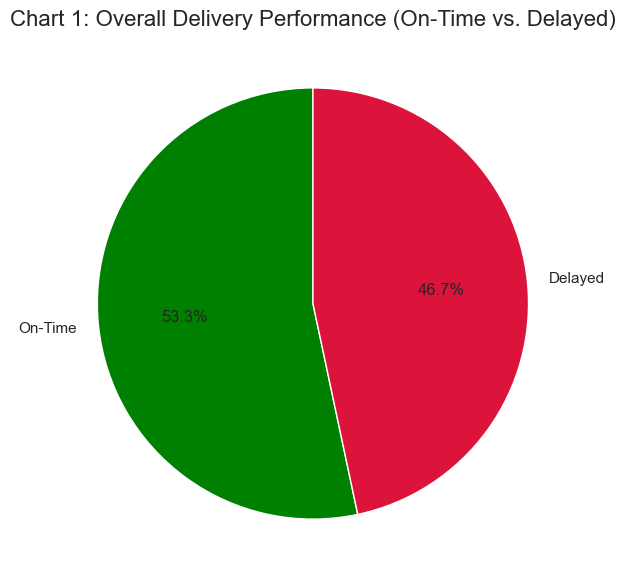


--- Visualization 2: Average Delivery Cost by Priority ---


C:\Users\lenovo\AppData\Local\Temp\ipykernel_7416\1264444335.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_completed,


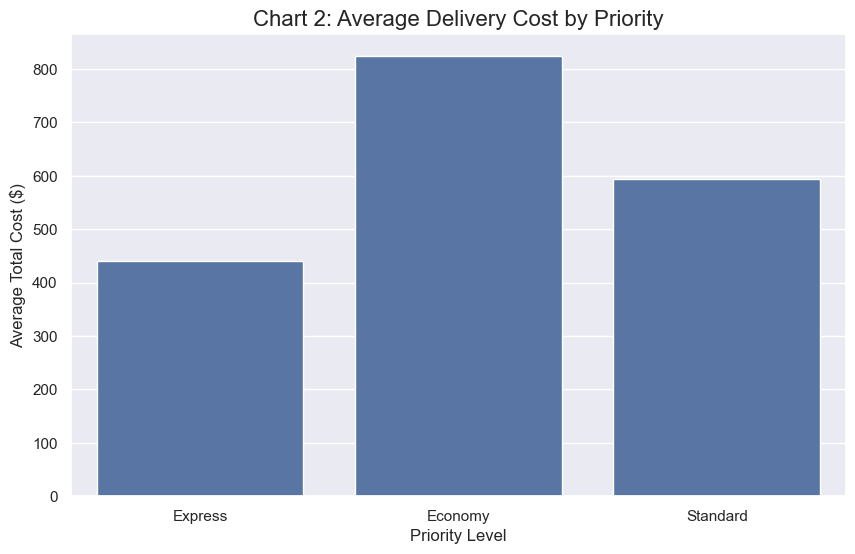


--- Visualization 3: Distribution of Delivery Delays (for delayed orders) ---


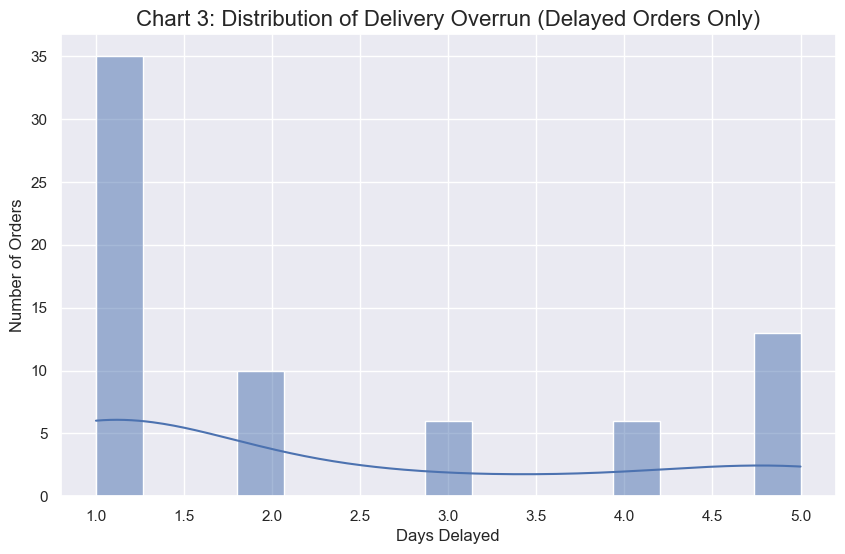


--- Visualization 4: Breakdown of Quality Issues ---


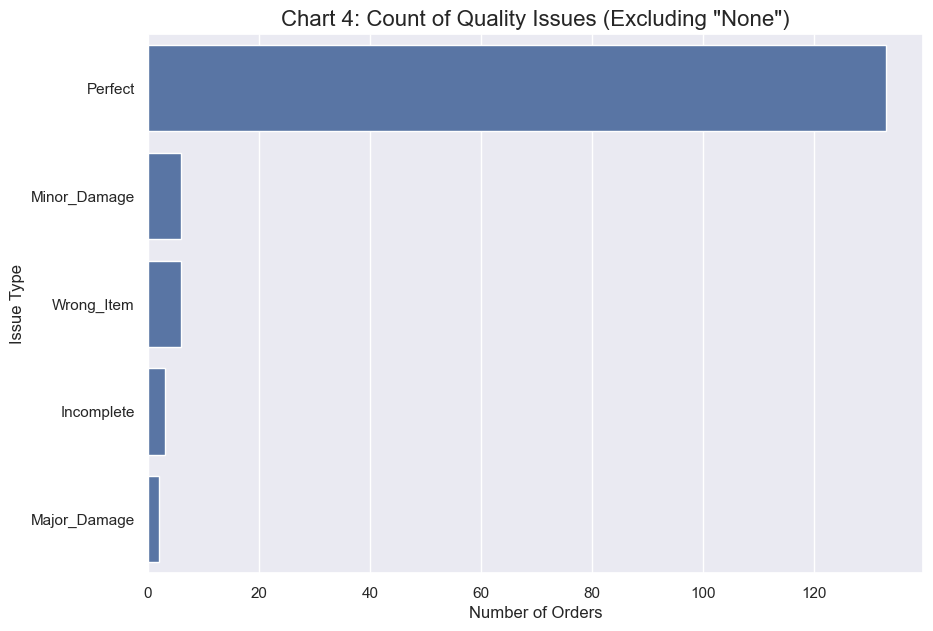


--- Visualization 5: Customer Rating vs. Delivery Delay ---


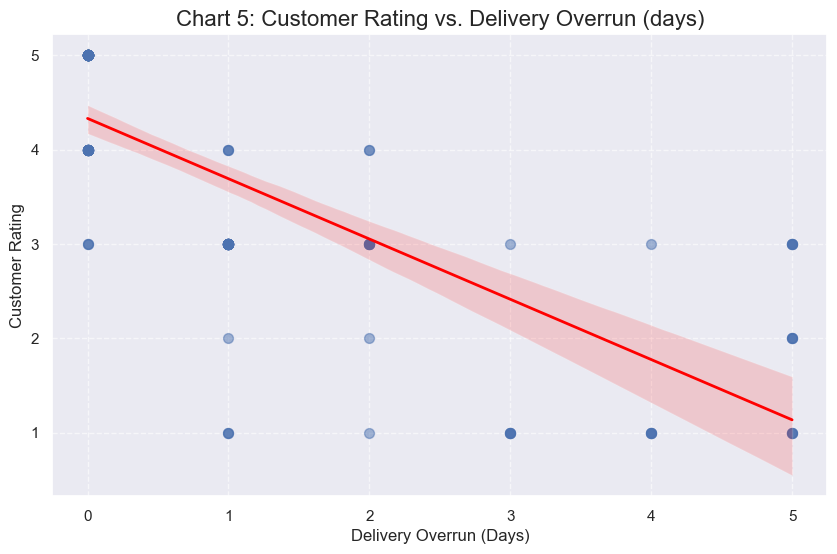

In [17]:
# --- Main Execution ---
if __name__ == "__main__":
    # Step 1. Load Data
    all_data_frames = load_all_data(DATA_PATH)
    
    if all_data_frames:
        # Step 2. Analyze, Clean, and Derive Metrics
        completed_df, pending_df, found_keys = analyze_data(all_data_frames)
        
        # Step 3. Print Key Insights
        if completed_df is not None:
            print_insights(completed_df, pending_df, found_keys)
            
            # --- STEP 4: CALL MATPLOTLIB/SEABORN VISUALIZATION ---
            visualize_data(completed_df, pending_df, found_keys)
            
        else:
            print("Analysis was halted due to fatal errors. Skipping insights and visualization.")